# Import data of london_weather in csv as 'df'
# Remodify data to be monthly

In [22]:
#import library
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

df = pd.read_csv('./london_weather.csv')
df.drop(columns = ['snow_depth'], inplace = True) # drop the entire column named 'snow_depth'
df.dropna(inplace= True) # drop any NaN 

# if there is NaN data dropped, there will be a gap between index, this code is to reset indexes to be sequent
df.reset_index(drop=True, inplace=True)

# get mean monthly temp
df['date'] = pd.to_datetime(df['date'],format='%Y%m%d') # read 'date' as YearMonthDay, no space or other symbols in the middle
df['month'] = pd.DatetimeIndex(df['date']).month # store the value of Month
df['year'] = pd.DatetimeIndex(df['date']).year # store the value of Year
df['month_year'] = pd.to_datetime(df['date']).dt.to_period('M') # combine Year and Month because data will be turned to be monthly
df=df.groupby('month_year').mean() # calculate the average of values in the same month_year in the same column

df # show

,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,month,year
month_year,,,,,,,,,,
1979-01,5.724138,2.017241,29.965517,4.144828,0.527586,-2.641379,2.058621,101120.689655,1.0,1979.0
1979-02,6.360000,1.948000,45.440000,4.428000,2.028000,-0.348000,1.744000,101061.600000,2.0,1979.0
1979-03,5.967742,3.212903,93.354839,9.238710,5.587097,1.993548,3.061290,100459.032258,3.0,1979.0
1979-04,6.133333,3.543333,134.166667,12.520000,8.743333,4.810000,2.586667,101165.333333,4.0,1979.0
1979-05,5.290323,6.470968,204.064516,16.206452,11.490323,7.151613,2.806452,101362.580645,5.0,1979.0
...,...,...,...,...,...,...,...,...,...,...
2020-08,5.066667,5.976667,208.100000,25.200000,20.393333,15.640000,1.873333,101219.333333,8.0,2020.0
2020-09,4.200000,6.540000,170.000000,21.693333,16.616667,11.580000,0.640000,101695.000000,9.0,2020.0
2020-10,5.733333,1.780000,70.533333,14.970000,11.933333,8.933333,4.773333,100794.333333,10.0,2020.0


# Split data into train / test sets as the ratio of 8:2

In [2]:
# as a result, 404 sets for training and 100 sets for testing
n=int(len(df)*0.2)
train = df.iloc[:len(df)-n]
test = df.iloc[len(df)-n:]

test # check


,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,month,year
month_year,,,,,,,,,,
2012-09,3.500000,5.963333,135.733333,19.770000,15.133333,10.276667,1.373333,101508.333333,9.0,2012.0
2012-10,5.967742,2.761290,64.967742,14.006452,11.125806,7.961290,2.851613,100992.580645,10.0,2012.0
2012-11,5.133333,2.513333,39.666667,10.826667,7.803333,4.580000,2.393333,100957.333333,11.0,2012.0
2012-12,5.129032,1.870968,24.870968,9.038710,5.812903,2.606452,3.090323,100823.870968,12.0,2012.0
2013-01,6.387097,1.112903,24.580645,6.529032,4.296774,2.016129,1.616129,101362.580645,1.0,2013.0
...,...,...,...,...,...,...,...,...,...,...
2020-08,5.066667,5.976667,208.100000,25.200000,20.393333,15.640000,1.873333,101219.333333,8.0,2020.0
2020-09,4.200000,6.540000,170.000000,21.693333,16.616667,11.580000,0.640000,101695.000000,9.0,2020.0
2020-10,5.733333,1.780000,70.533333,14.970000,11.933333,8.933333,4.773333,100794.333333,10.0,2020.0


# Build up a multi variable ARIMA model

In [ ]:
# this step usually takes a few hours

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm

# parameters (p, d, q) are determined manually, considering ACF and PACF plots in the other file 'parameter_selection'
model = sm.tsa.VARMAX(#VARMAX is a variant of ARIMA for multi variables
                endog = train[['mean_temp', 'min_temp', 'max_temp', 'cloud_cover', 'sunshine', 'global_radiation', 'precipitation', 'pressure']], # input variables
                order = (12, 4),  # manually selected order by considering ACF and PACF plots in 'parameters selection'
                seasonal_order =(12, 0, 4, 12))# seasonal order is to turn on the seasonality of this model
  


C:\Users\CJyM2\Documents\anaconda\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


In [6]:
result = model.fit(maxiter=2000, disp=False) # maxiter means iterations, disp means 
result.summary()

Dep. Variable:,"['mean_temp', 'min_temp', 'max_temp', 'cloud_cover', 'sunshine', 'global_radiation', 'precipitation', 'pressure']",No. Observations:,404
Model:,"VARMA(12,4)",Log Likelihood,-5204.880
,+ intercept,AIC,12545.761
Date:,"Thu, 06 Apr 2023",BIC,16819.272
Time:,04:18:36,HQIC,14237.462
Sample:,01-31-1979,,
,- 08-31-2012,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"0.01, 0.01, 0.01, 0.37, 0.03, 0.00, 0.05, 0.01",Jarque-Bera (JB):,"2.56, 2.21, 0.55, 8.15, 2.07, 2.00, 24.41, 1.07"
Prob(Q):,"0.92, 0.93, 0.93, 0.54, 0.86, 0.99, 0.83, 0.92",Prob(JB):,"0.28, 0.33, 0.76, 0.02, 0.35, 0.37, 0.00, 0.59"
Heteroskedasticity (H):,"0.90, 1.11, 0.95, 0.84, 0.88, 1.11, 0.82, 0.88",Skew:,"0.05, 0.02, -0.06, 0.17, -0.09, 0.13, 0.50, -0.06"


In [4]:
result.aic
# the lower the better, a few thousands for the single variable case, this result is acceptable

12545.760532860291

# Predicting from the end of the training set until 60 months after the entire set 'df'

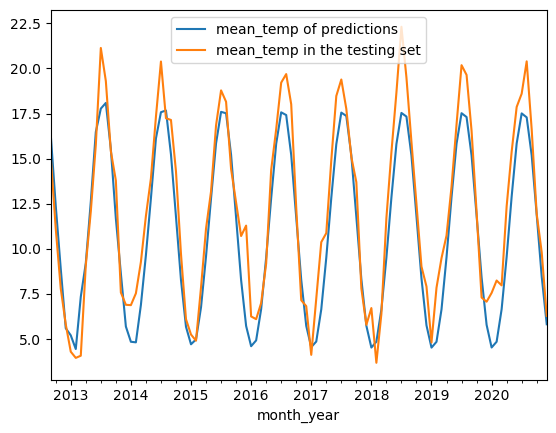

In [5]:
#Predictions of ARIMA Model against the test set
start = len(train) # starting from the end of the training set
end = len(df) + 60 # 60 months for forecasting

# Predictions covering the testing set and 60 months after that
predictions = result.predict(start, end, dynamic=True, return_conf_int=True)
# dynamic=True means new predicted values will be attached to the end of dataset for further prediction
# because ARIMA model depends on historical inputs

# Plot predictions and actual values on the same graph
predictions['mean_temp'].iloc[:len(test)].plot(legend = True) # only plot the first 100 elements
test['mean_temp'].plot(legend = True)

plt.legend(["mean_temp of predictions", "mean_temp in the testing set"]) # label values clearly

plt.show()

# Validation

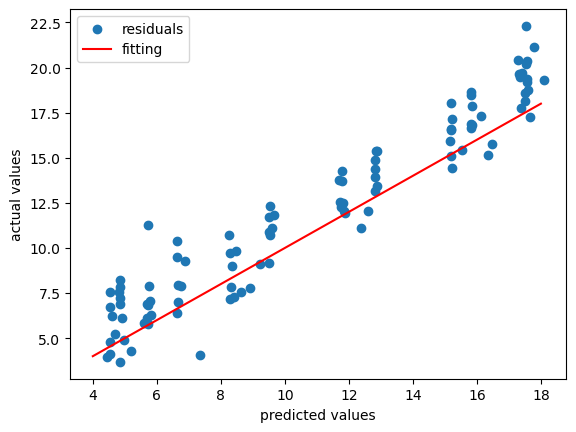

In [33]:
#plot residuals to see errors intuitively
plt.scatter(predictions['mean_temp'].iloc[:len(test)], test['mean_temp'])
plt.xlabel('predicted values')
plt.ylabel('actual values')

# plot fitting values as reference
x=pd.Series(range(4,19))
y=x
plt.plot(x, y, color='red')

plt.legend(["residuals", "fitting"]) #label values clearly

plt.show()

In [8]:
# Validation by MSE and RMSE
# Load specific evaluation tools
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
  
# Calculate root mean squared error 
RMSE=rmse(test["mean_temp"], predictions["mean_temp"].iloc[:len(test)])
  
# Calculate mean squared error
MSE=mean_squared_error(test["mean_temp"], predictions["mean_temp"].iloc[:len(test)])

In [9]:
RMSE

1.8571939188493038

In [10]:
MSE

3.4491692522108344

# Forecasting 5 years

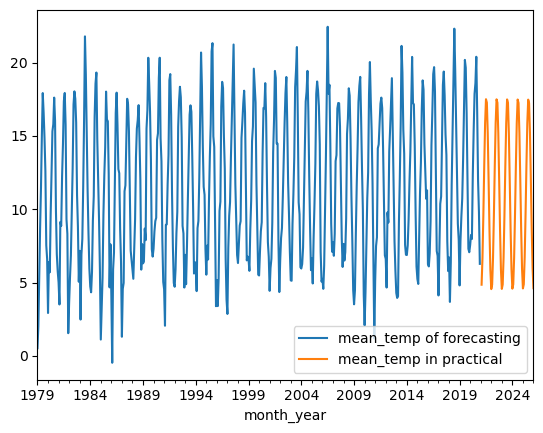

In [34]:
# plot the original data of mean_temp in 'df' and forecasting values of mean_temp in 'predictions' on the same graph
df['mean_temp'].plot(legend = True)
predictions['mean_temp'].iloc[-60:].plot(legend = True)

plt.legend(["mean_temp of forecasting", "mean_temp in practical"]) #label values clearly
plt.show()

#store predicted values in a csv file
predictions.to_csv('forecast_multi.csv', header=True, index=False, encoding='utf-8')

In [13]:
predictions

,mean_temp,min_temp,max_temp,cloud_cover,sunshine,global_radiation,precipitation,pressure
2012-09,16.353136,11.888264,20.727643,4.148970,4.995378,126.113657,2.175467,101600.529901
2012-10,12.393354,8.839990,15.849683,4.814222,3.495197,75.225505,1.721571,101581.356363
2012-11,8.901246,5.737803,11.980952,5.143667,1.958751,37.312437,2.364766,101502.159705
2012-12,5.595868,2.978623,8.183067,5.694327,0.657750,9.498086,2.204341,101110.676885
2013-01,5.203088,2.078432,8.271626,4.924710,2.253078,32.298720,2.128135,101719.898789
...,...,...,...,...,...,...,...,...
2025-09,15.230625,11.069382,19.289434,4.964791,4.627831,128.813609,1.847052,101495.121443
2025-10,12.061360,8.418239,15.580982,5.142152,3.343497,79.170180,1.935877,101471.302453
2025-11,8.667998,5.479476,11.744416,5.335036,2.229560,39.192762,1.945994,101478.286162
2025-12,5.969068,3.035303,8.828532,5.474328,1.608741,18.979605,1.870195,101514.775950


In [23]:
test

,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,month,year
month_year,,,,,,,,,,
2012-09,3.500000,5.963333,135.733333,19.770000,15.133333,10.276667,1.373333,101508.333333,9.0,2012.0
2012-10,5.967742,2.761290,64.967742,14.006452,11.125806,7.961290,2.851613,100992.580645,10.0,2012.0
2012-11,5.133333,2.513333,39.666667,10.826667,7.803333,4.580000,2.393333,100957.333333,11.0,2012.0
2012-12,5.129032,1.870968,24.870968,9.038710,5.812903,2.606452,3.090323,100823.870968,12.0,2012.0
2013-01,6.387097,1.112903,24.580645,6.529032,4.296774,2.016129,1.616129,101362.580645,1.0,2013.0
...,...,...,...,...,...,...,...,...,...,...
2020-08,5.066667,5.976667,208.100000,25.200000,20.393333,15.640000,1.873333,101219.333333,8.0,2020.0
2020-09,4.200000,6.540000,170.000000,21.693333,16.616667,11.580000,0.640000,101695.000000,9.0,2020.0
2020-10,5.733333,1.780000,70.533333,14.970000,11.933333,8.933333,4.773333,100794.333333,10.0,2020.0
